# External independent tests report 2016-2023 (part 2)

## Intro
This is a second part of Ukrainian EIT/NMT report (2016-2023). Due to limitation of publication size the report was split up into parts. The first part you can find here: [Part 1](https://app.datacamp.com/workspace/w/72a99b69-d71f-497b-b0be-ca93429e511f) 

## Load libraries

Loading R libraries

In [1]:
library(tidyverse)
library(data.table)
library(ggplot2)

Warning message:
"package 'tidyr' was built under R version 4.3.2"
Warning message:
"package 'readr' was built under R version 4.3.2"
Warning message:
"package 'purrr' was built under R version 4.3.2"
Warning message:
"package 'dplyr' was built under R version 4.3.2"
Warning message:
"package 'stringr' was built under R version 4.3.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'data.table' was built under R version 4.3.2"

Attaching package: 'data.table'


The following objects are masked

## Read Data

Read CSV file from source into a datatable. Raw data from [UCEQA](https://zno.testportal.com.ua/opendata) has been processed,enriched, and cleaned by me. R scripts for data prep and cleansing you can find in [git](https://github.com/sapotec/eit-ukraine)

In [2]:
zno_raw <- fread(
  cmd = "unzip -cq outputs/ZNO_2016+_raw_data.zip",
  na.strings = "", dec = ".", encoding = "UTF-8", quote = ""
)


## Data preparation
Compose datasets for visualization


Explore source dataset. Check values consistency within columns

In [3]:
zno <- zno_raw %>%
  mutate(across(c(matches("name$|test$|lang$|status$")), as.factor)) %>%
  relocate(classprofilename, classlangname, .after = tertypename)


Pivot dataset to long. It contains test results in 100-200 balls scale by subject, gender, settlement type, and students graduate type

In [4]:
zno_long_ball100 <- zno %>%
  select(
    year, outid, sextypename, tertypename, regtypename,
    matches("test$"), matches("ball100$")
  ) %>%
  select(-msttest) %>%
  mutate(across(matches("ball100$"), as.double)) %>%
  melt(
    id.vars = c(
      "year", "outid", "sextypename",
      "tertypename", "regtypename"
    ), na.rm = TRUE,
    measure.vars = patterns(test = "test$", ball100 = "ball100$"),
    value.factor = TRUE
  ) %>%
  select(-variable) %>%
  filter(ball100 > 0)


Plot options

In [15]:
options(
  scipen = 5, repr.plot.width = 12,
  repr.plot.height = 8, repr.plot.res = 300
)

capt <- "Data source:UCEQA(testportal.gov.ua) | Created by: Taras Nyzhnyk"

caption <- labs(caption = capt)

general_plot_config <- theme_minimal() + theme(
  # plot title and caption settings
  plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
  plot.caption = element_text(color = "#757575"),
  plot.caption.position = "plot",
  # axis titles
  axis.title.x = element_text(size = 10, face = "bold"),
  axis.title.y = element_blank(),
  # axis text
  axis.text.x = element_text(size = 10),
  # legend settings
  legend.title = element_text(size = 8, face = "bold"),
  legend.position = "top",
  legend.text = element_text(size = 8),
  # strip for facets
  strip.text = element_text(size = 10, face = "bold")
)


Constant variables

In [16]:
levels_grad <- c(
  "Студент закладу вищої-фахової передвищої освіти",
  "Студент закладу вищої освіти", "Учень закладу професійної освіти",
  "Випускник минулих років", "Випускник поточного року"
)

levels_m_subj <- c(
  "Українська мова і література",
  "Історія України", "Математика"
)

levels_n_subj <- c("Фізика", "Хімія", "Біологія", "Географія")

levels_l_subj <- c(
  "Українська мова", "Англійська мова", "Французька мова",
  "Німецька мова", "Іспанська мова", "Російська мова"
)


## 2. Test result metrics

### 2.1 EIT test results distribution by gender 

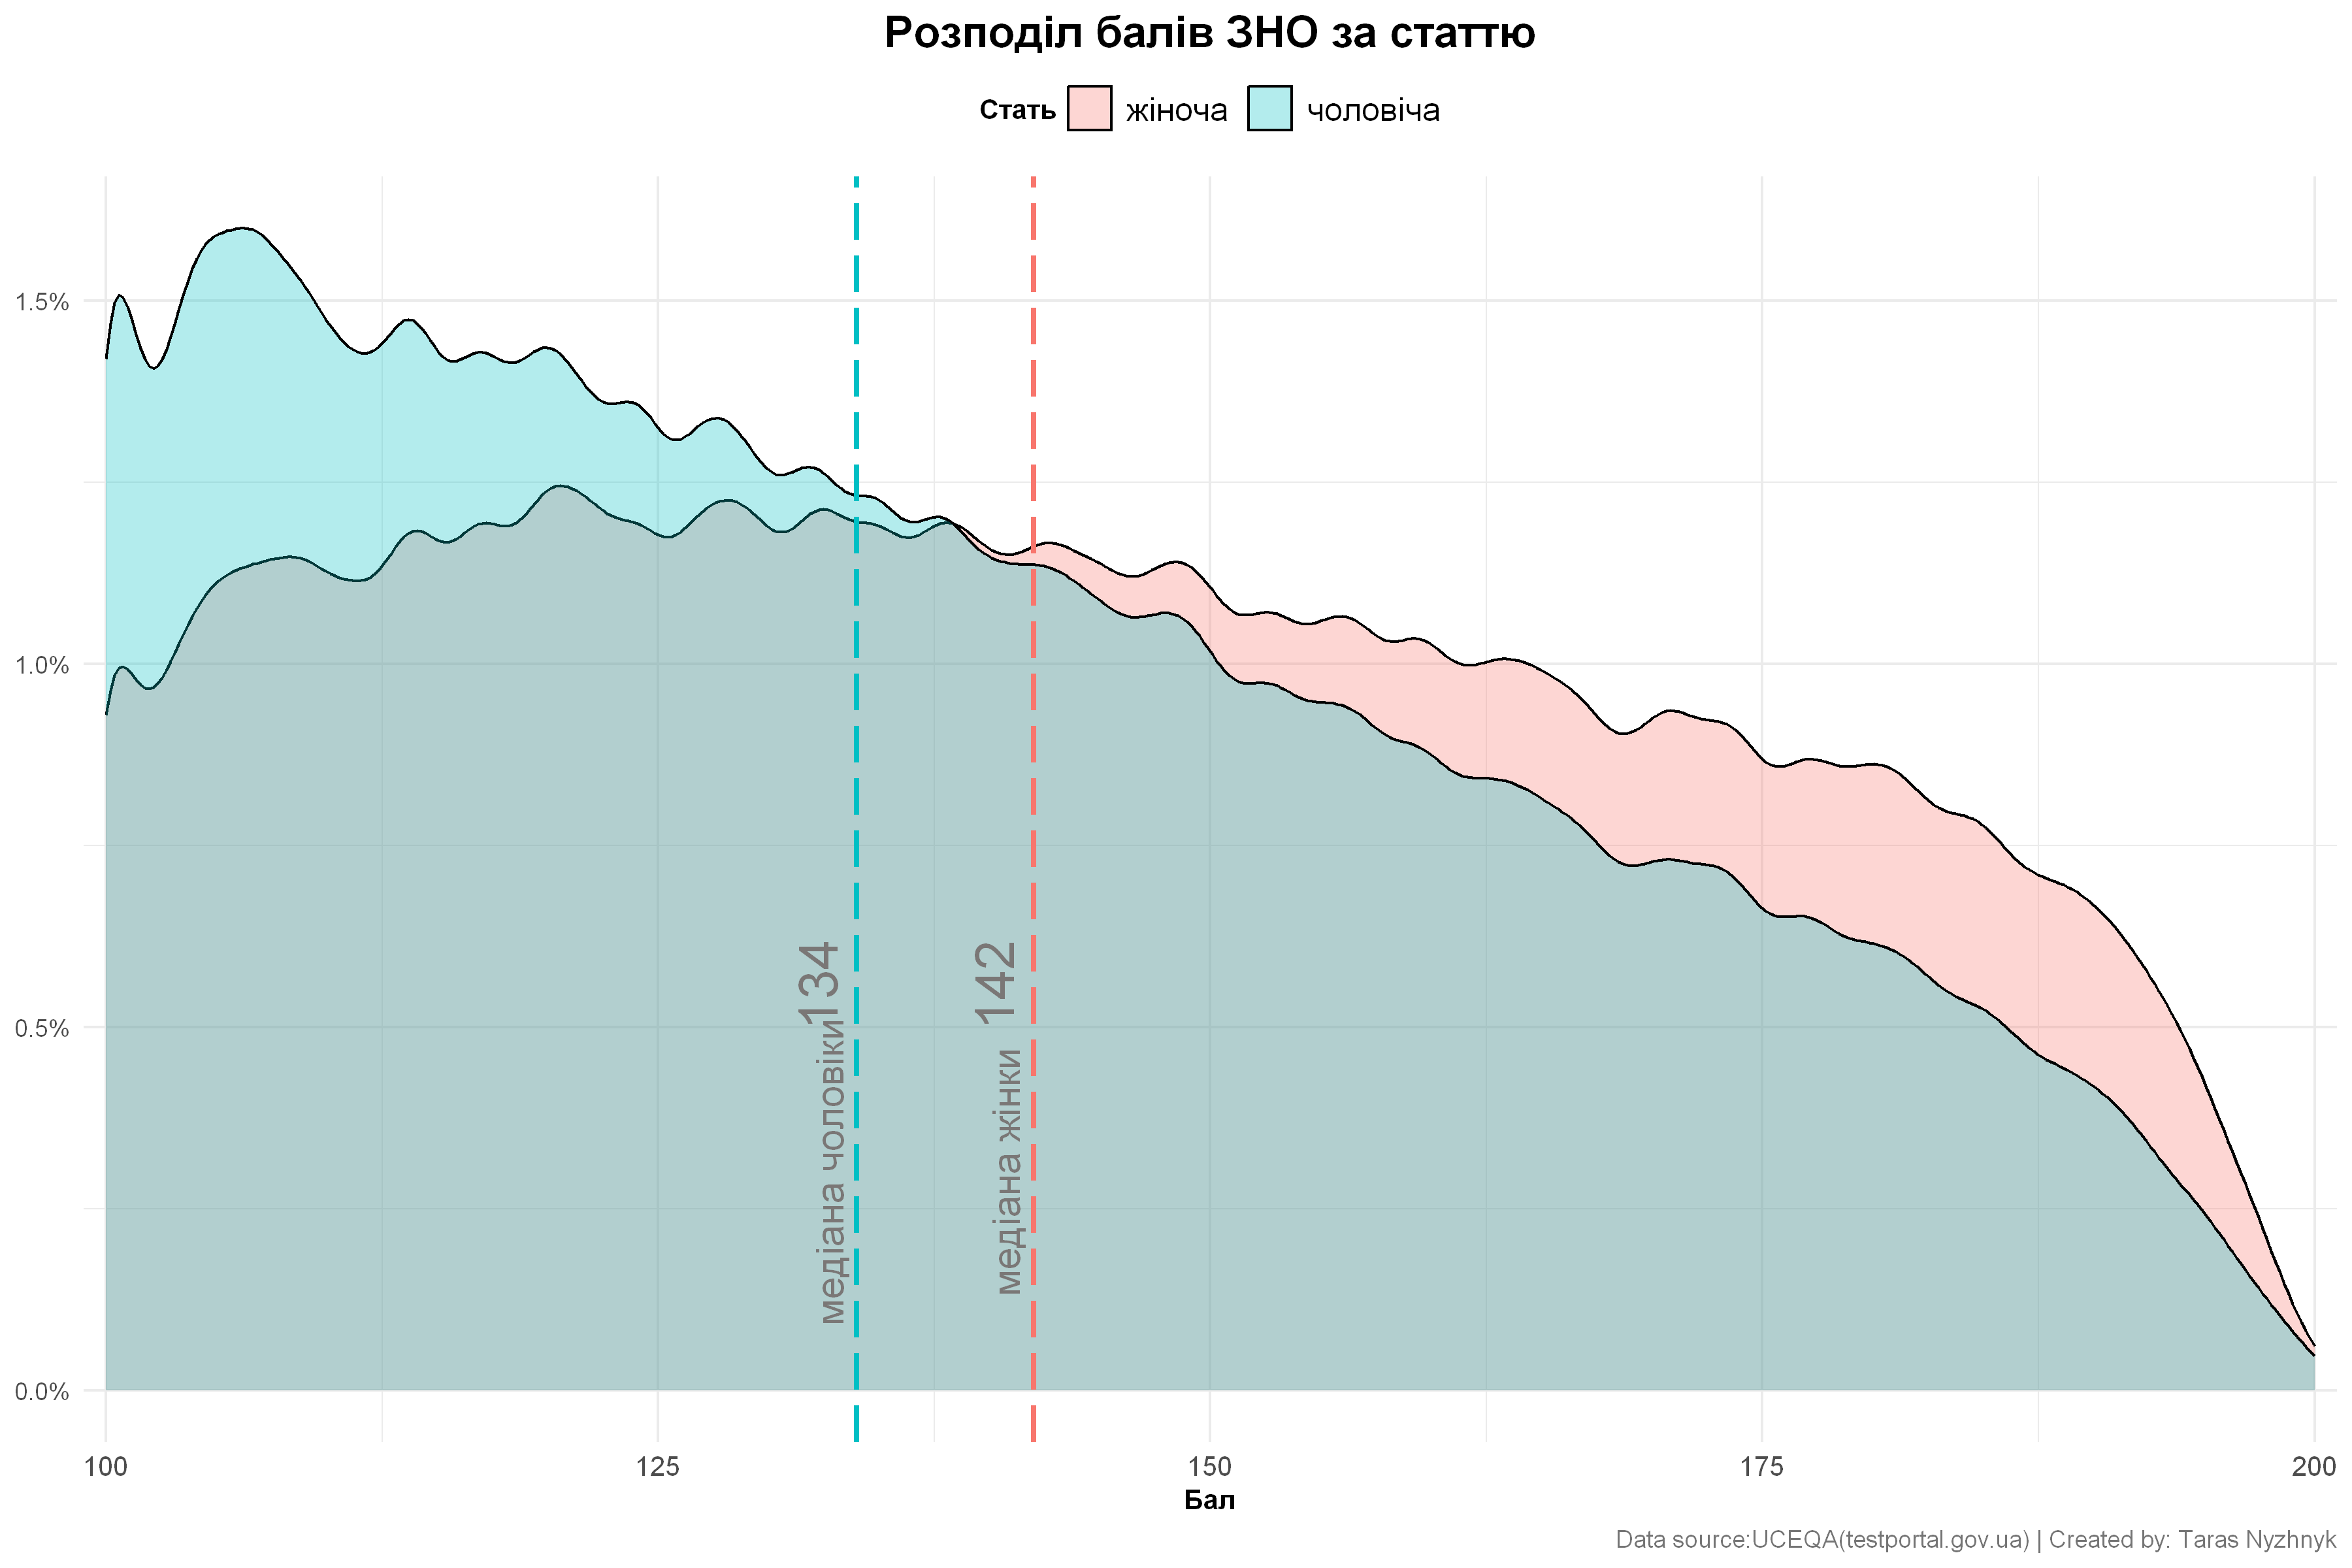

In [17]:
# calculate average ball per gender for EIT results
mball_zno <- zno_long_ball100 %>%
  filter(year < 2022) %>%
  group_by(sextypename) %>%
  summarize(s.median = median(ball100))

# exclude results of NMT from dataset
score_by_gender_zno <- zno_long_ball100 %>%
  filter(year < 2022)

ggplot(score_by_gender_zno) +
  aes(
    x = ball100,
    y = after_stat(density),
    group = sextypename,
    fill = sextypename
  ) +
  geom_density(alpha = .3) +
  geom_vline(aes(xintercept = s.median, color = sextypename),
    data = mball_zno, linetype = "longdash", linewidth = 1, show.legend = FALSE
  ) +
  geom_text(
    data = mball_zno, aes(x = s.median, y = 0, label = s.median),
    angle = 90, hjust = -4, vjust = -0.5, size = 7, color = "#7A7776"
  ) +
  scale_y_continuous(labels = scales::percent, expand = c(0.0007, 0.0007)) +
  scale_x_continuous(limits = c(100, 200), expand = c(0.01, 0.01)) +
  labs(fill = "Стать", x = "Бал") +
  ggtitle("Розподіл балів ЗНО за статтю") +
  caption +
  general_plot_config +
  theme(
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 12),
  ) +
  annotate(
    geom = "text", x = mball_zno$s.median[mball_zno$sextypename == "чоловіча"],
    y = 0.003, label = "медіана чоловіки",
    size = 5, color = "#7A7776", angle = 90, vjust = -0.5
  ) +
  annotate(
    geom = "text", x = mball_zno$s.median[mball_zno$sextypename == "жіноча"],
    y = 0.003, label = "медіана жінки",
    size = 5, color = "#7A7776", angle = 90, vjust = -0.5
  )


### 2.2 NMT test results distribution by gender

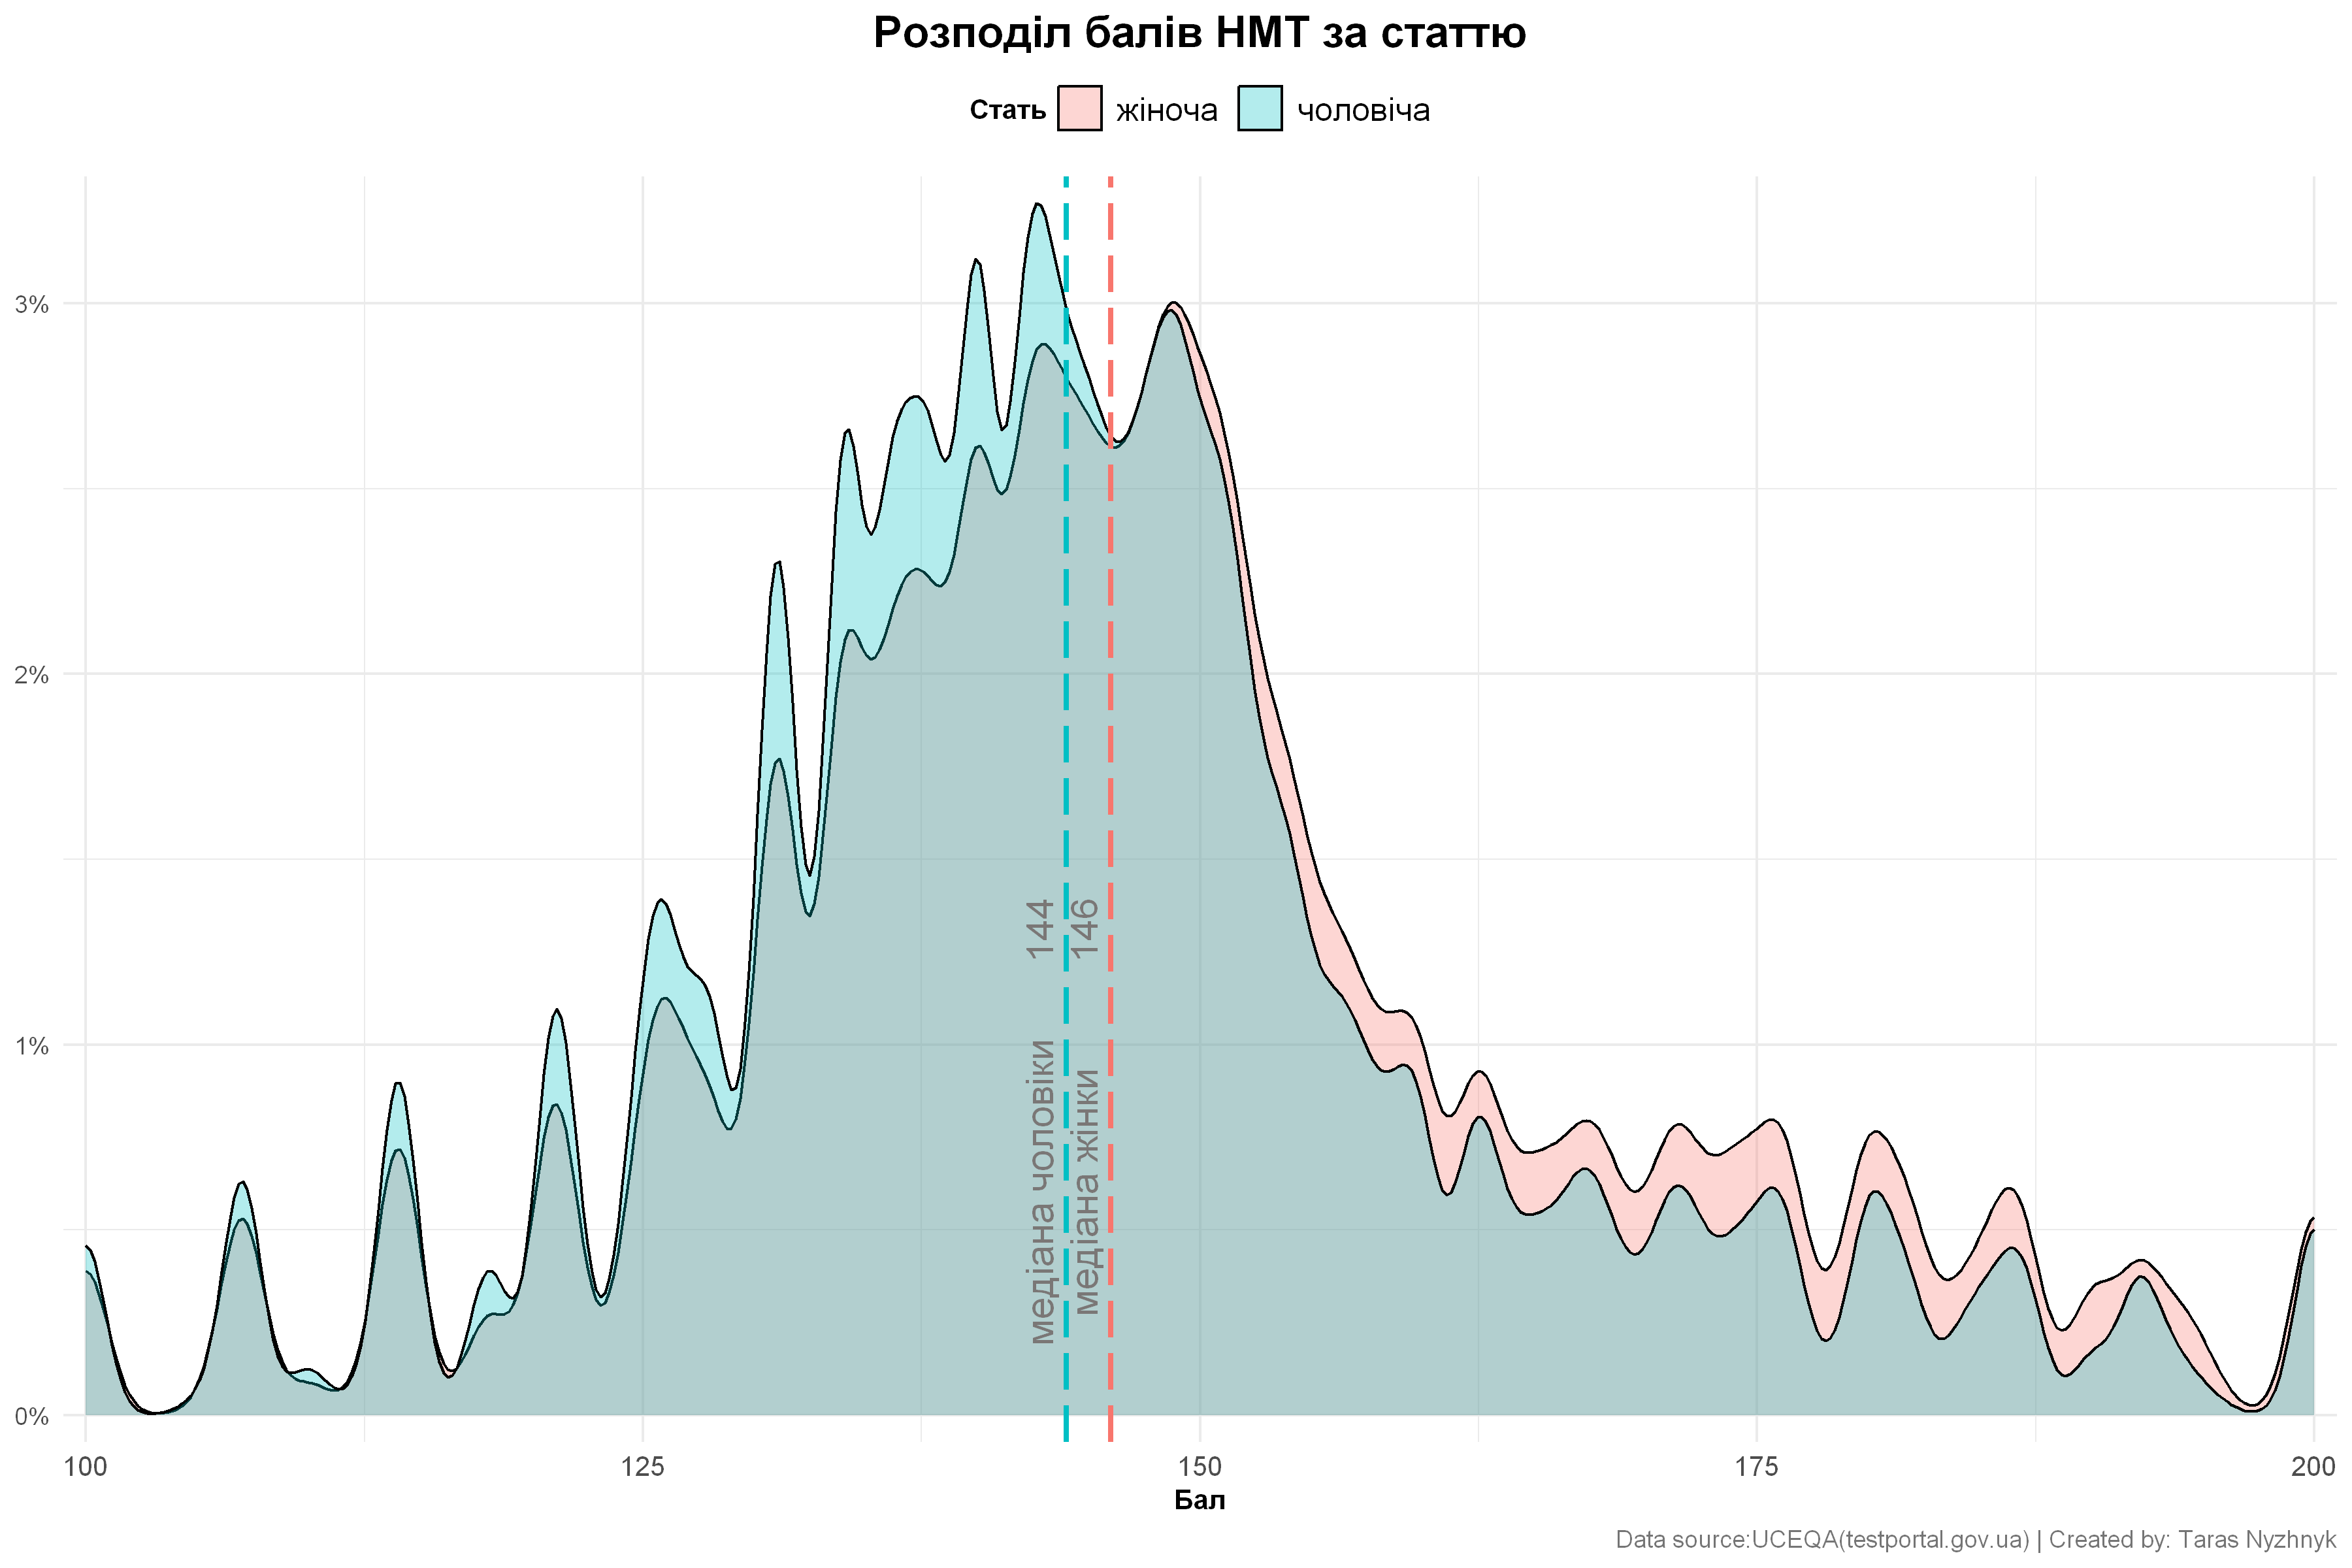

In [18]:
# calculate average ball per gender NMT tests
mball_nmt <- zno_long_ball100 %>%
  filter(year >= 2022) %>%
  group_by(sextypename) %>%
  summarize(s.median = median(ball100))

# extract NMT results from dataset
score_by_gender_nmt <- zno_long_ball100 %>%
  filter(year >= 2022)

ggplot(score_by_gender_nmt) +
  aes(
    x = ball100,
    y = after_stat(density),
    group = sextypename,
    fill = sextypename
  ) +
  geom_density(alpha = .3) +
  geom_vline(
    data = mball_nmt, aes(xintercept = s.median, color = sextypename),
    linetype = "longdash", linewidth = 1, show.legend = FALSE
  ) +
  geom_text(
    data = mball_nmt, aes(x = s.median, y = 0, label = s.median),
    angle = 90, hjust = -7, vjust = -0.5, size = 5, color = "#7A7776"
  ) +
  scale_y_continuous(labels = scales::percent, expand = c(0.0007, 0.0007)) +
  scale_x_continuous(limits = c(100, 200), expand = c(0.01, 0.01)) +
  labs(fill = "Стать", x = "Бал") +
  ggtitle("Розподіл балів НМТ за статтю") +
  caption +
  general_plot_config +
  theme(
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 12),
  ) +
  annotate(
    geom = "text", x = mball_nmt$s.median[mball_nmt$sextypename == "чоловіча"],
    y = 0.006, label = "медіана чоловіки",
    size = 5, color = "#7A7776", angle = 90, vjust = -0.5
  ) +
  annotate(
    geom = "text", x = mball_nmt$s.median[mball_nmt$sextypename == "жіноча"],
    y = 0.006, label = "медіана жінки",
    size = 5, color = "#7A7776", angle = 90, vjust = -0.5
  )


### 2.3 Test results distribution by gender and subject(mandatory tests)

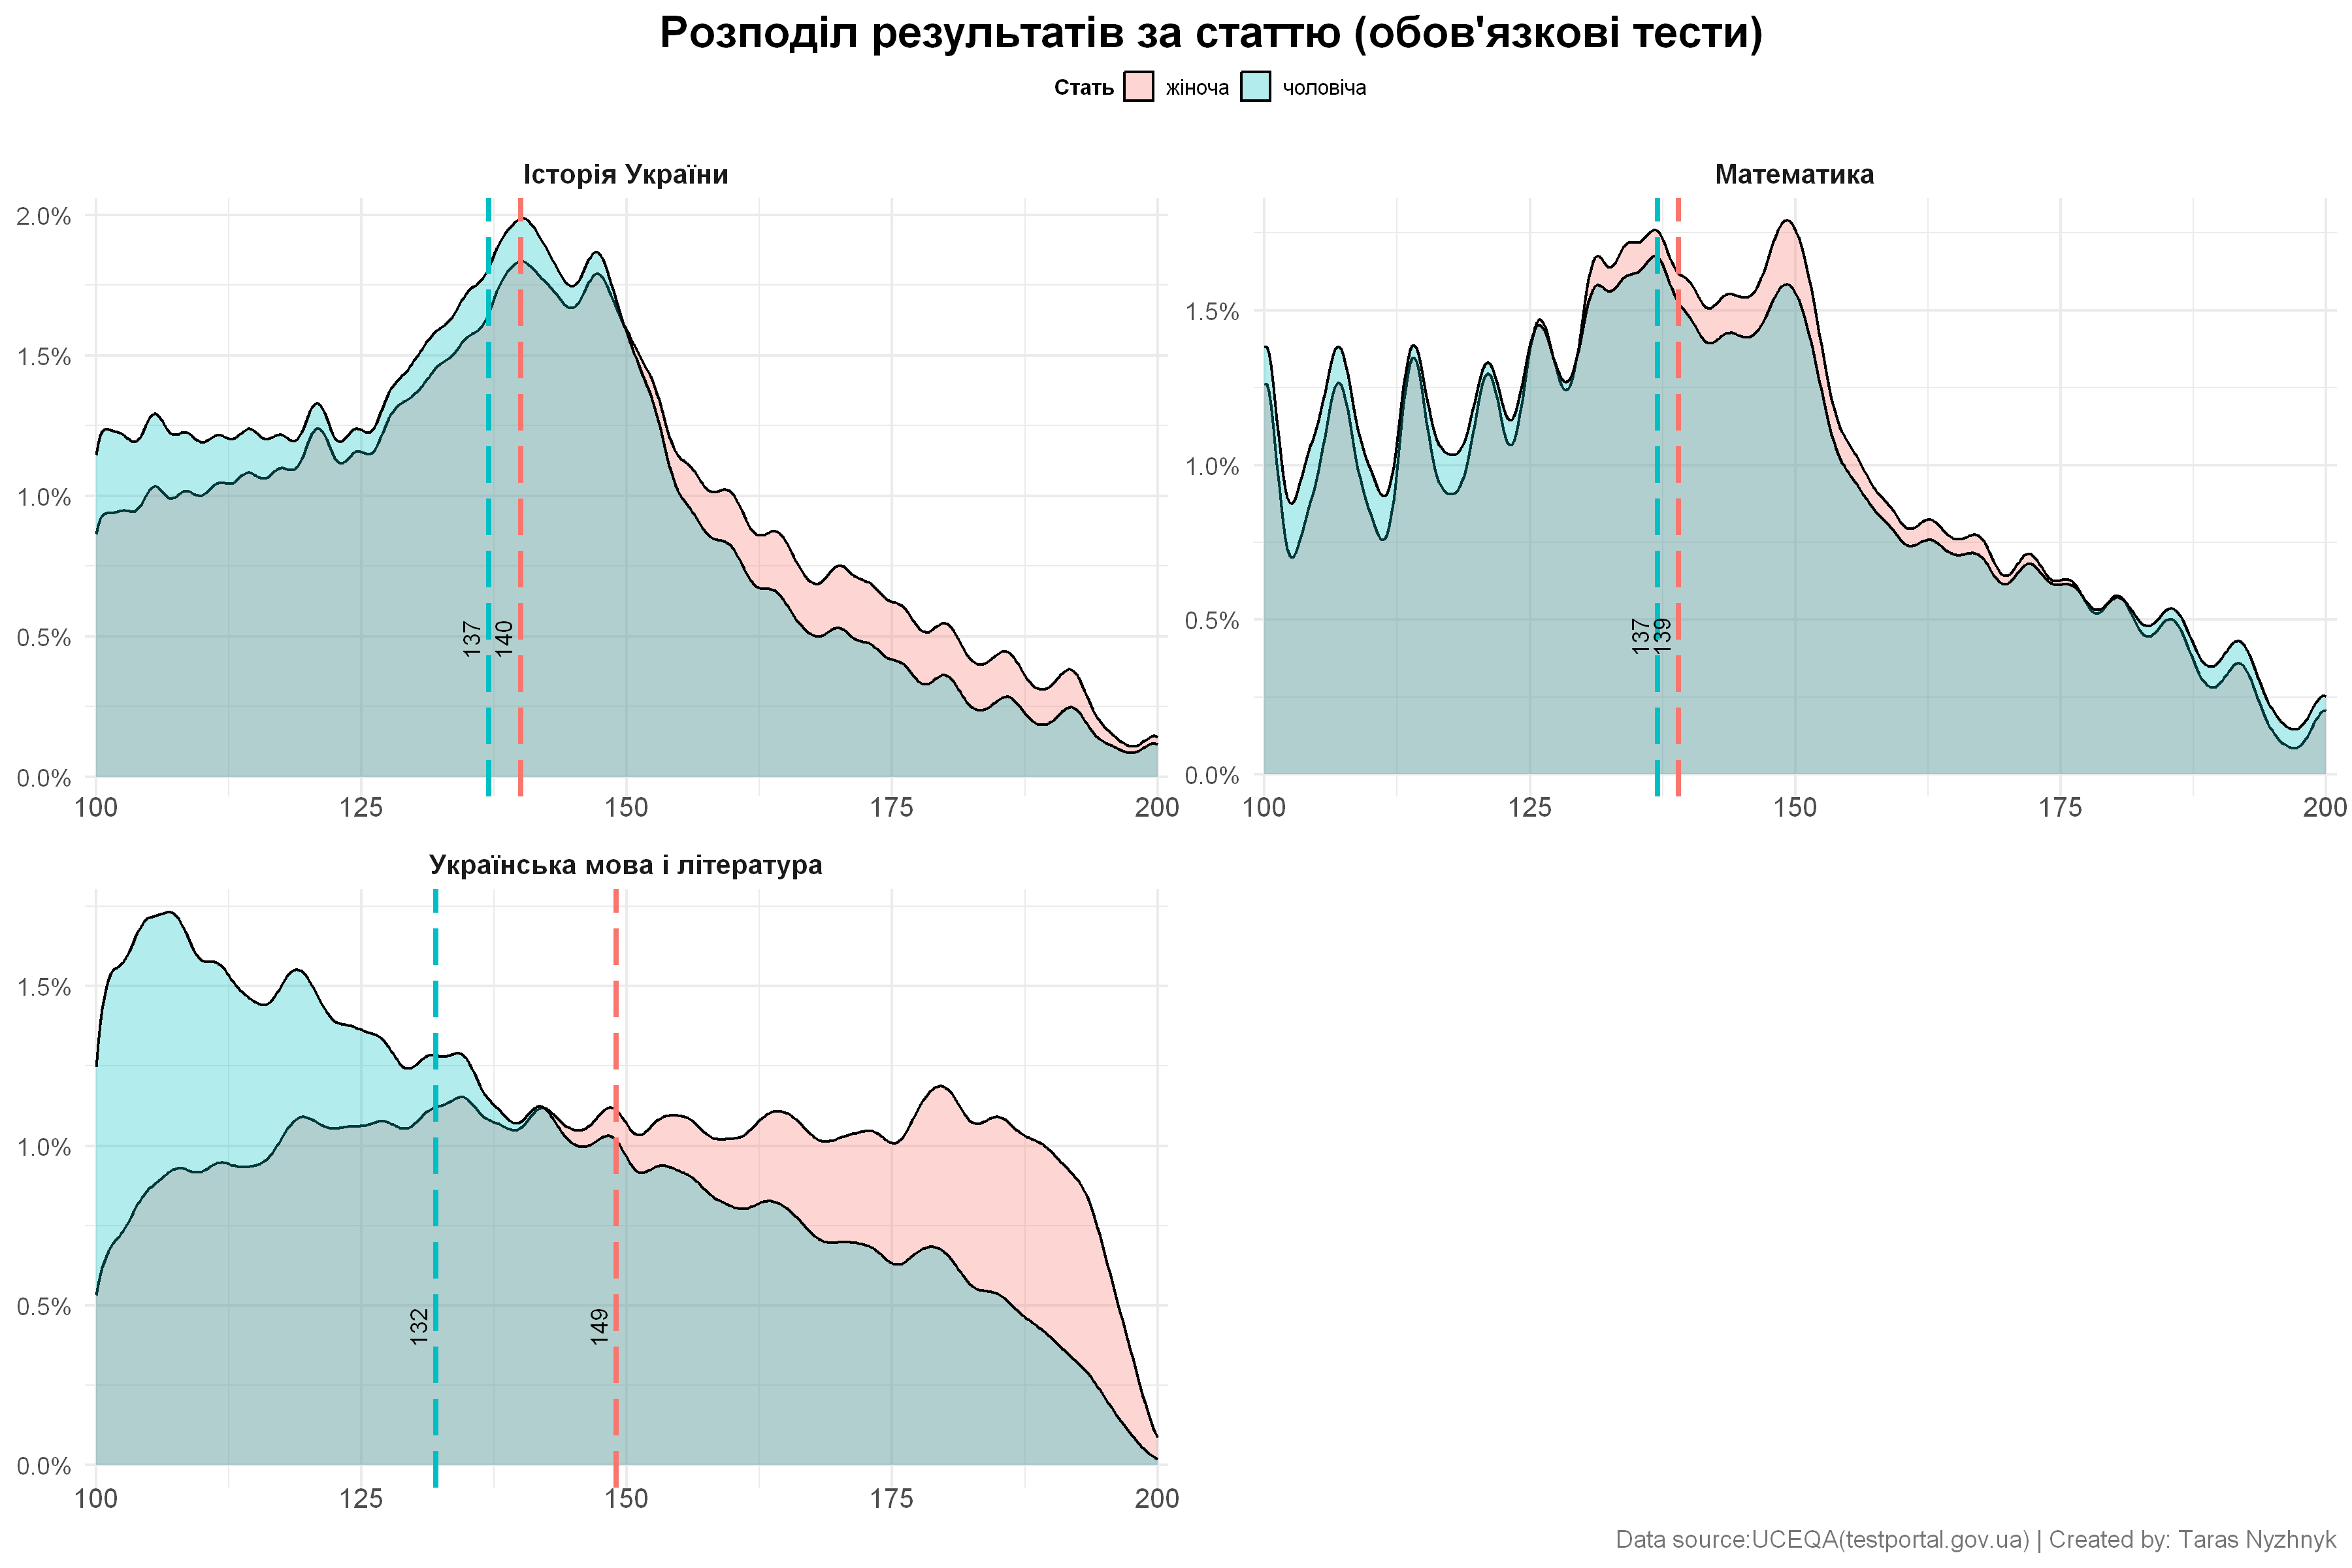

In [19]:
# calculate average ball fro mandatory subjects
mball_m_subj <- zno_long_ball100 %>%
  filter(test %in% levels_m_subj) %>%
  group_by(test, sextypename) %>%
  summarize(s.median = median(ball100), .groups = "keep")

# filter mandatory subjects results from dataset
score_by_gender_m_subj <- zno_long_ball100 %>%
  filter(test %in% levels_m_subj)

ggplot(score_by_gender_m_subj) +
  aes(
    x = ball100,
    y = after_stat(prop),
    fill = sextypename,
    group = sextypename
  ) +
  geom_density(aes(y = after_stat(density)), alpha = .3, adjust = .9) +
  geom_vline(
    data = mball_m_subj, aes(xintercept = s.median, color = sextypename),
    linetype = "longdash", linewidth = 1, show.legend = FALSE
  ) +
  geom_text(
    data = mball_m_subj, aes(x = s.median, y = 0, label = s.median),
    angle = 90, hjust = -3, vjust = -0.5, size = 3
  ) +
  scale_y_continuous(labels = scales::percent, expand = c(0.0007, 0.0007)) +
  scale_x_continuous(limits = c(100, 200), expand = c(0.01, 0.01)) +
  facet_wrap(. ~ test, scales = "free", ncol = 2) +
  labs(fill = "Стать", x = "Бал") +
  ggtitle("Розподіл результатів за статтю (обов'язкові тести)") +
  caption +
  general_plot_config +
  theme(
    plot.title = element_text(margin = margin(0, 0, 0, 0)),
    axis.title.x = element_blank(),
    axis.text.x = element_text(margin = margin(-3, 0, 0, 0)),
    legend.key.size = unit(12, "pt")
  )


### 2.4 Test results distribution by gender and subject (natural sciences)

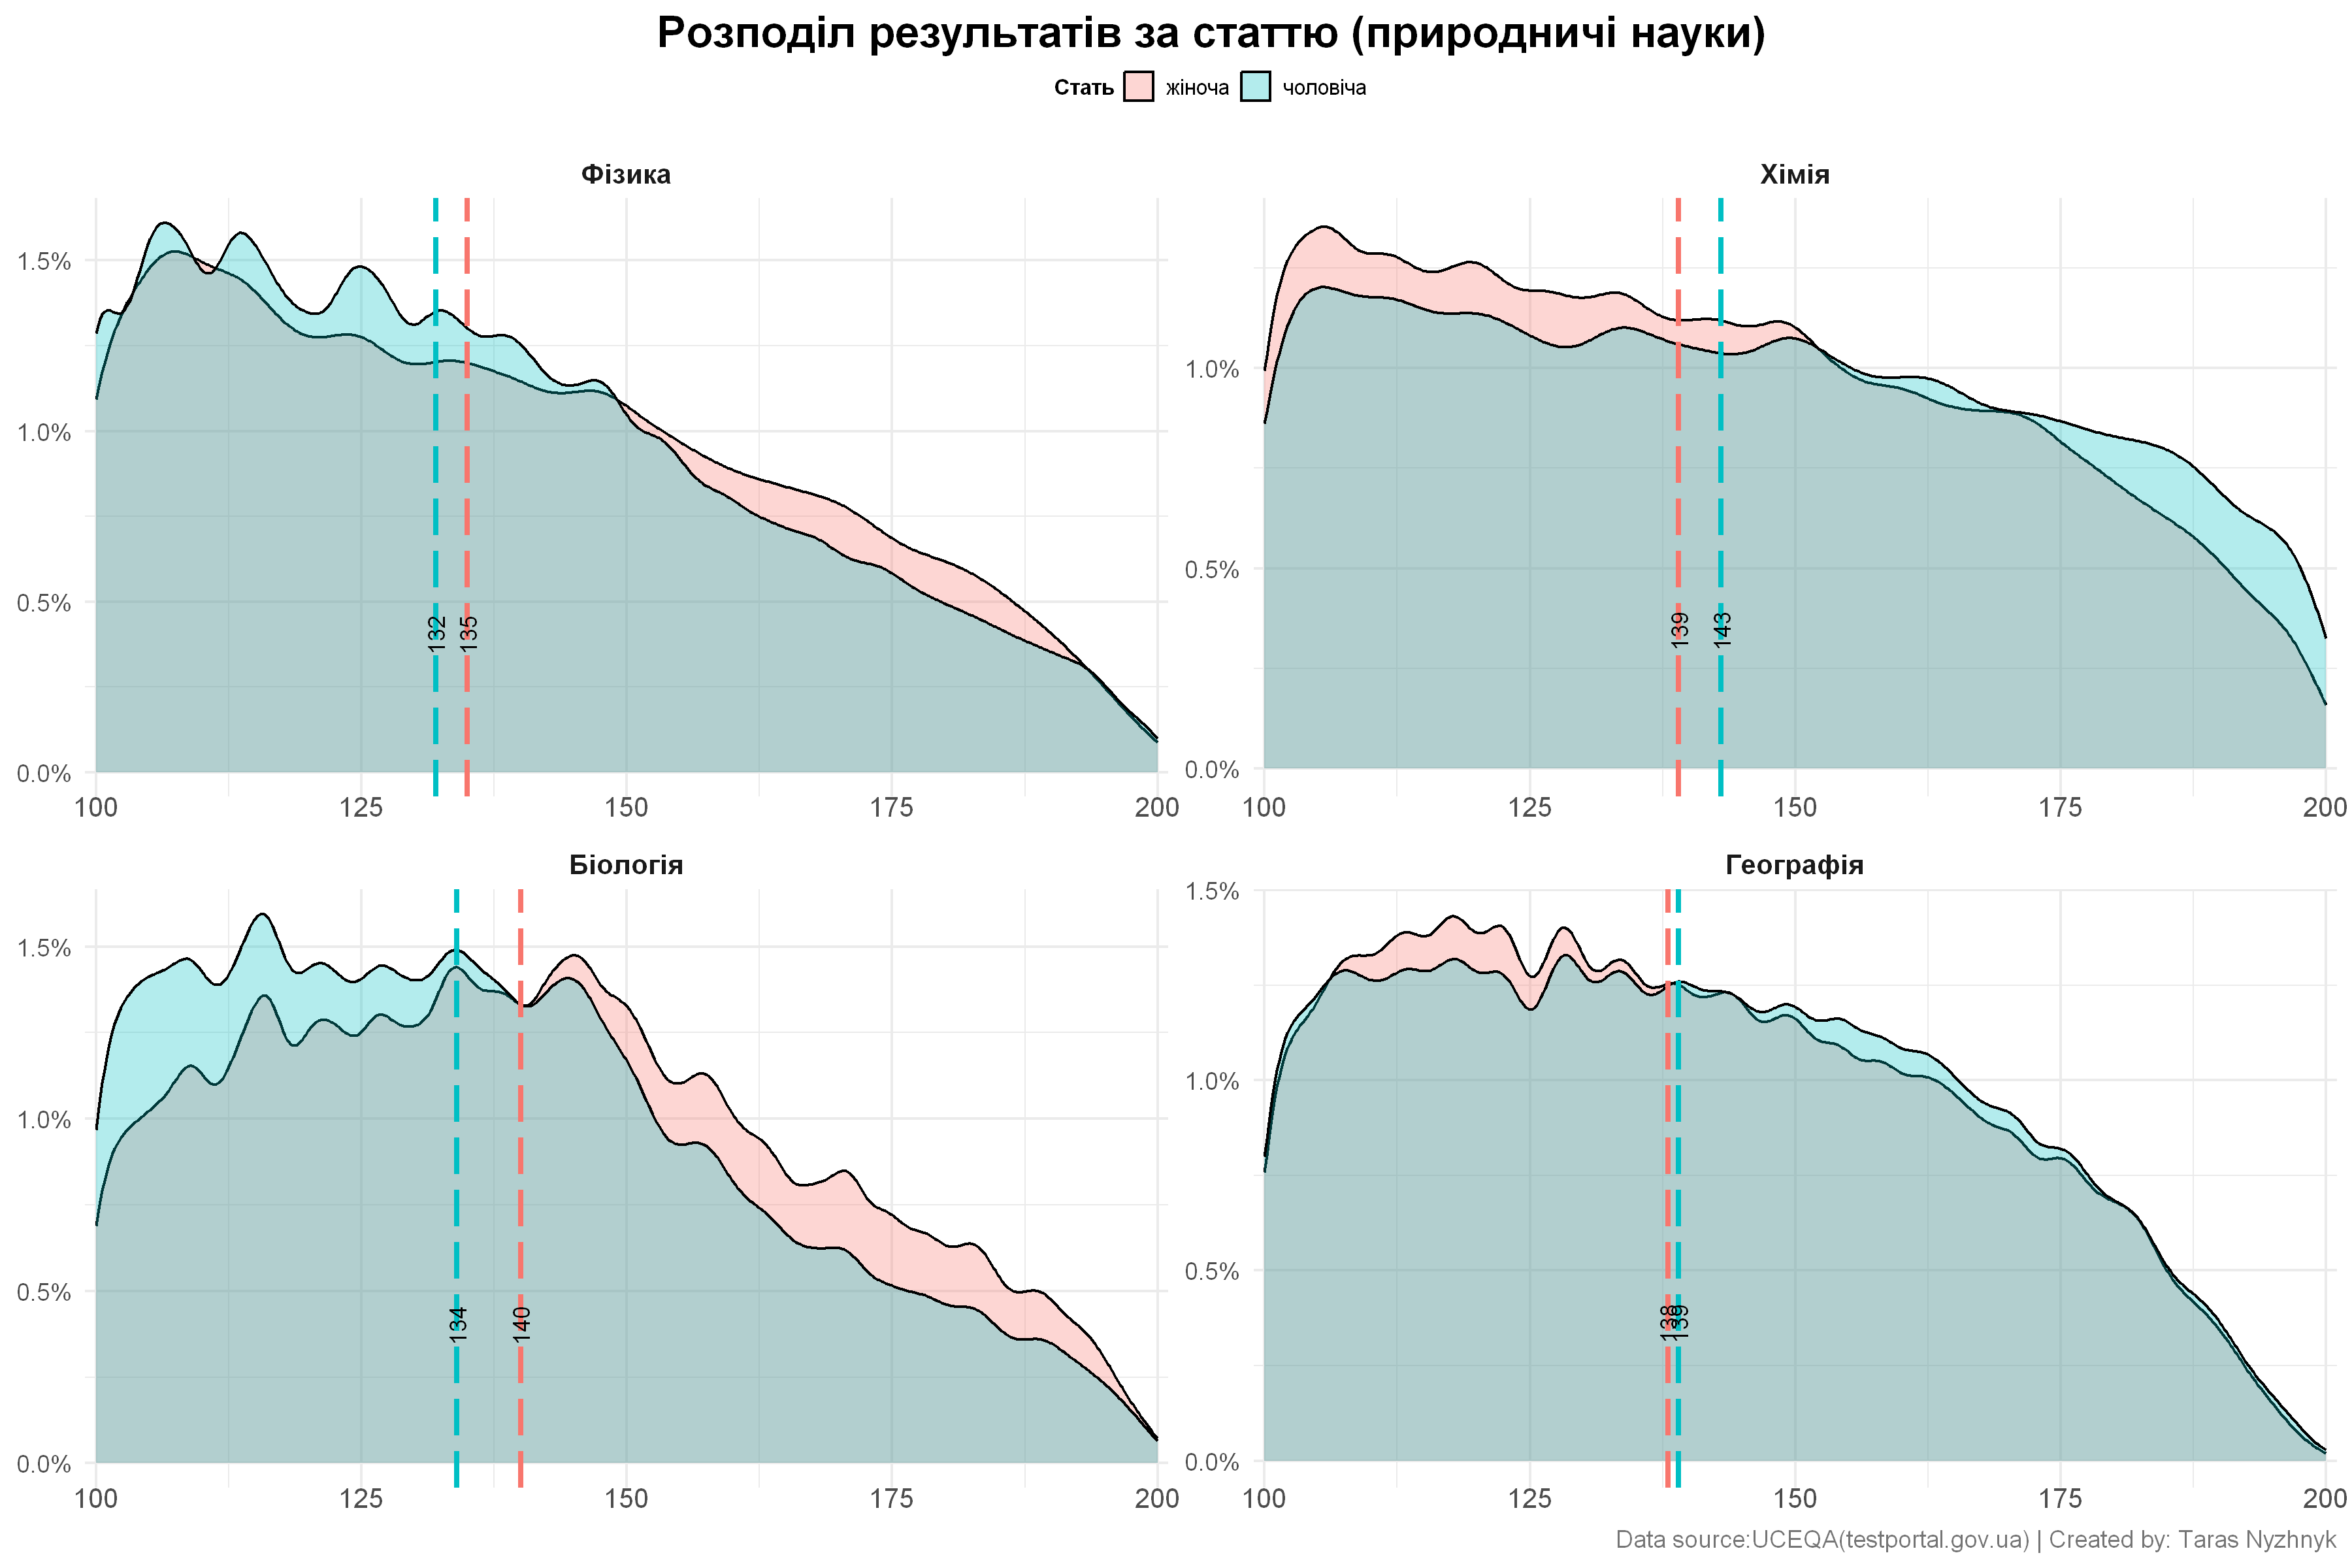

In [20]:
# calculate average ball per natural science subjects of EIT
mball_n_subj <- zno_long_ball100 %>%
  filter(test %in% levels_n_subj) %>%
  group_by(test, sextypename) %>%
  summarize(s.median = median(ball100), .groups = "keep")

score_by_gender_n_subj <- zno_long_ball100 %>%
  filter(test %in% levels_n_subj)

ggplot(score_by_gender_n_subj) +
  aes(
    x = ball100,
    y = after_stat(prop),
    fill = sextypename,
    group = sextypename
  ) +
  geom_density(aes(y = after_stat(density)), alpha = .3, adjust = .9) +
  geom_vline(
    data = mball_n_subj, aes(xintercept = s.median, color = sextypename),
    linetype = "longdash", linewidth = 1, show.legend = FALSE
  ) +
  geom_text(
    data = mball_n_subj, aes(x = s.median, y = 0, label = s.median),
    angle = 90, hjust = -3, vjust = 0.5, size = 3
  ) +
  scale_y_continuous(labels = scales::percent, expand = c(0.0007, 0.0007)) +
  scale_x_continuous(limits = c(100, 200), expand = c(0.01, 0.01)) +
  facet_wrap(. ~ test, scales = "free", ncol = 2) +
  labs(fill = "Стать", x = "Бал") +
  ggtitle("Розподіл результатів за статтю (природничі науки)") +
  caption +
  general_plot_config +
  theme(
    plot.title = element_text(margin = margin(0, 0, 0, 0)),
    axis.title.x = element_blank(),
    axis.text.x = element_text(margin = margin(-3, 0, 0, 0)),
    legend.key.size = unit(12, "pt")
  )


### 2.5 Test results distribution by gender and subject (languages)

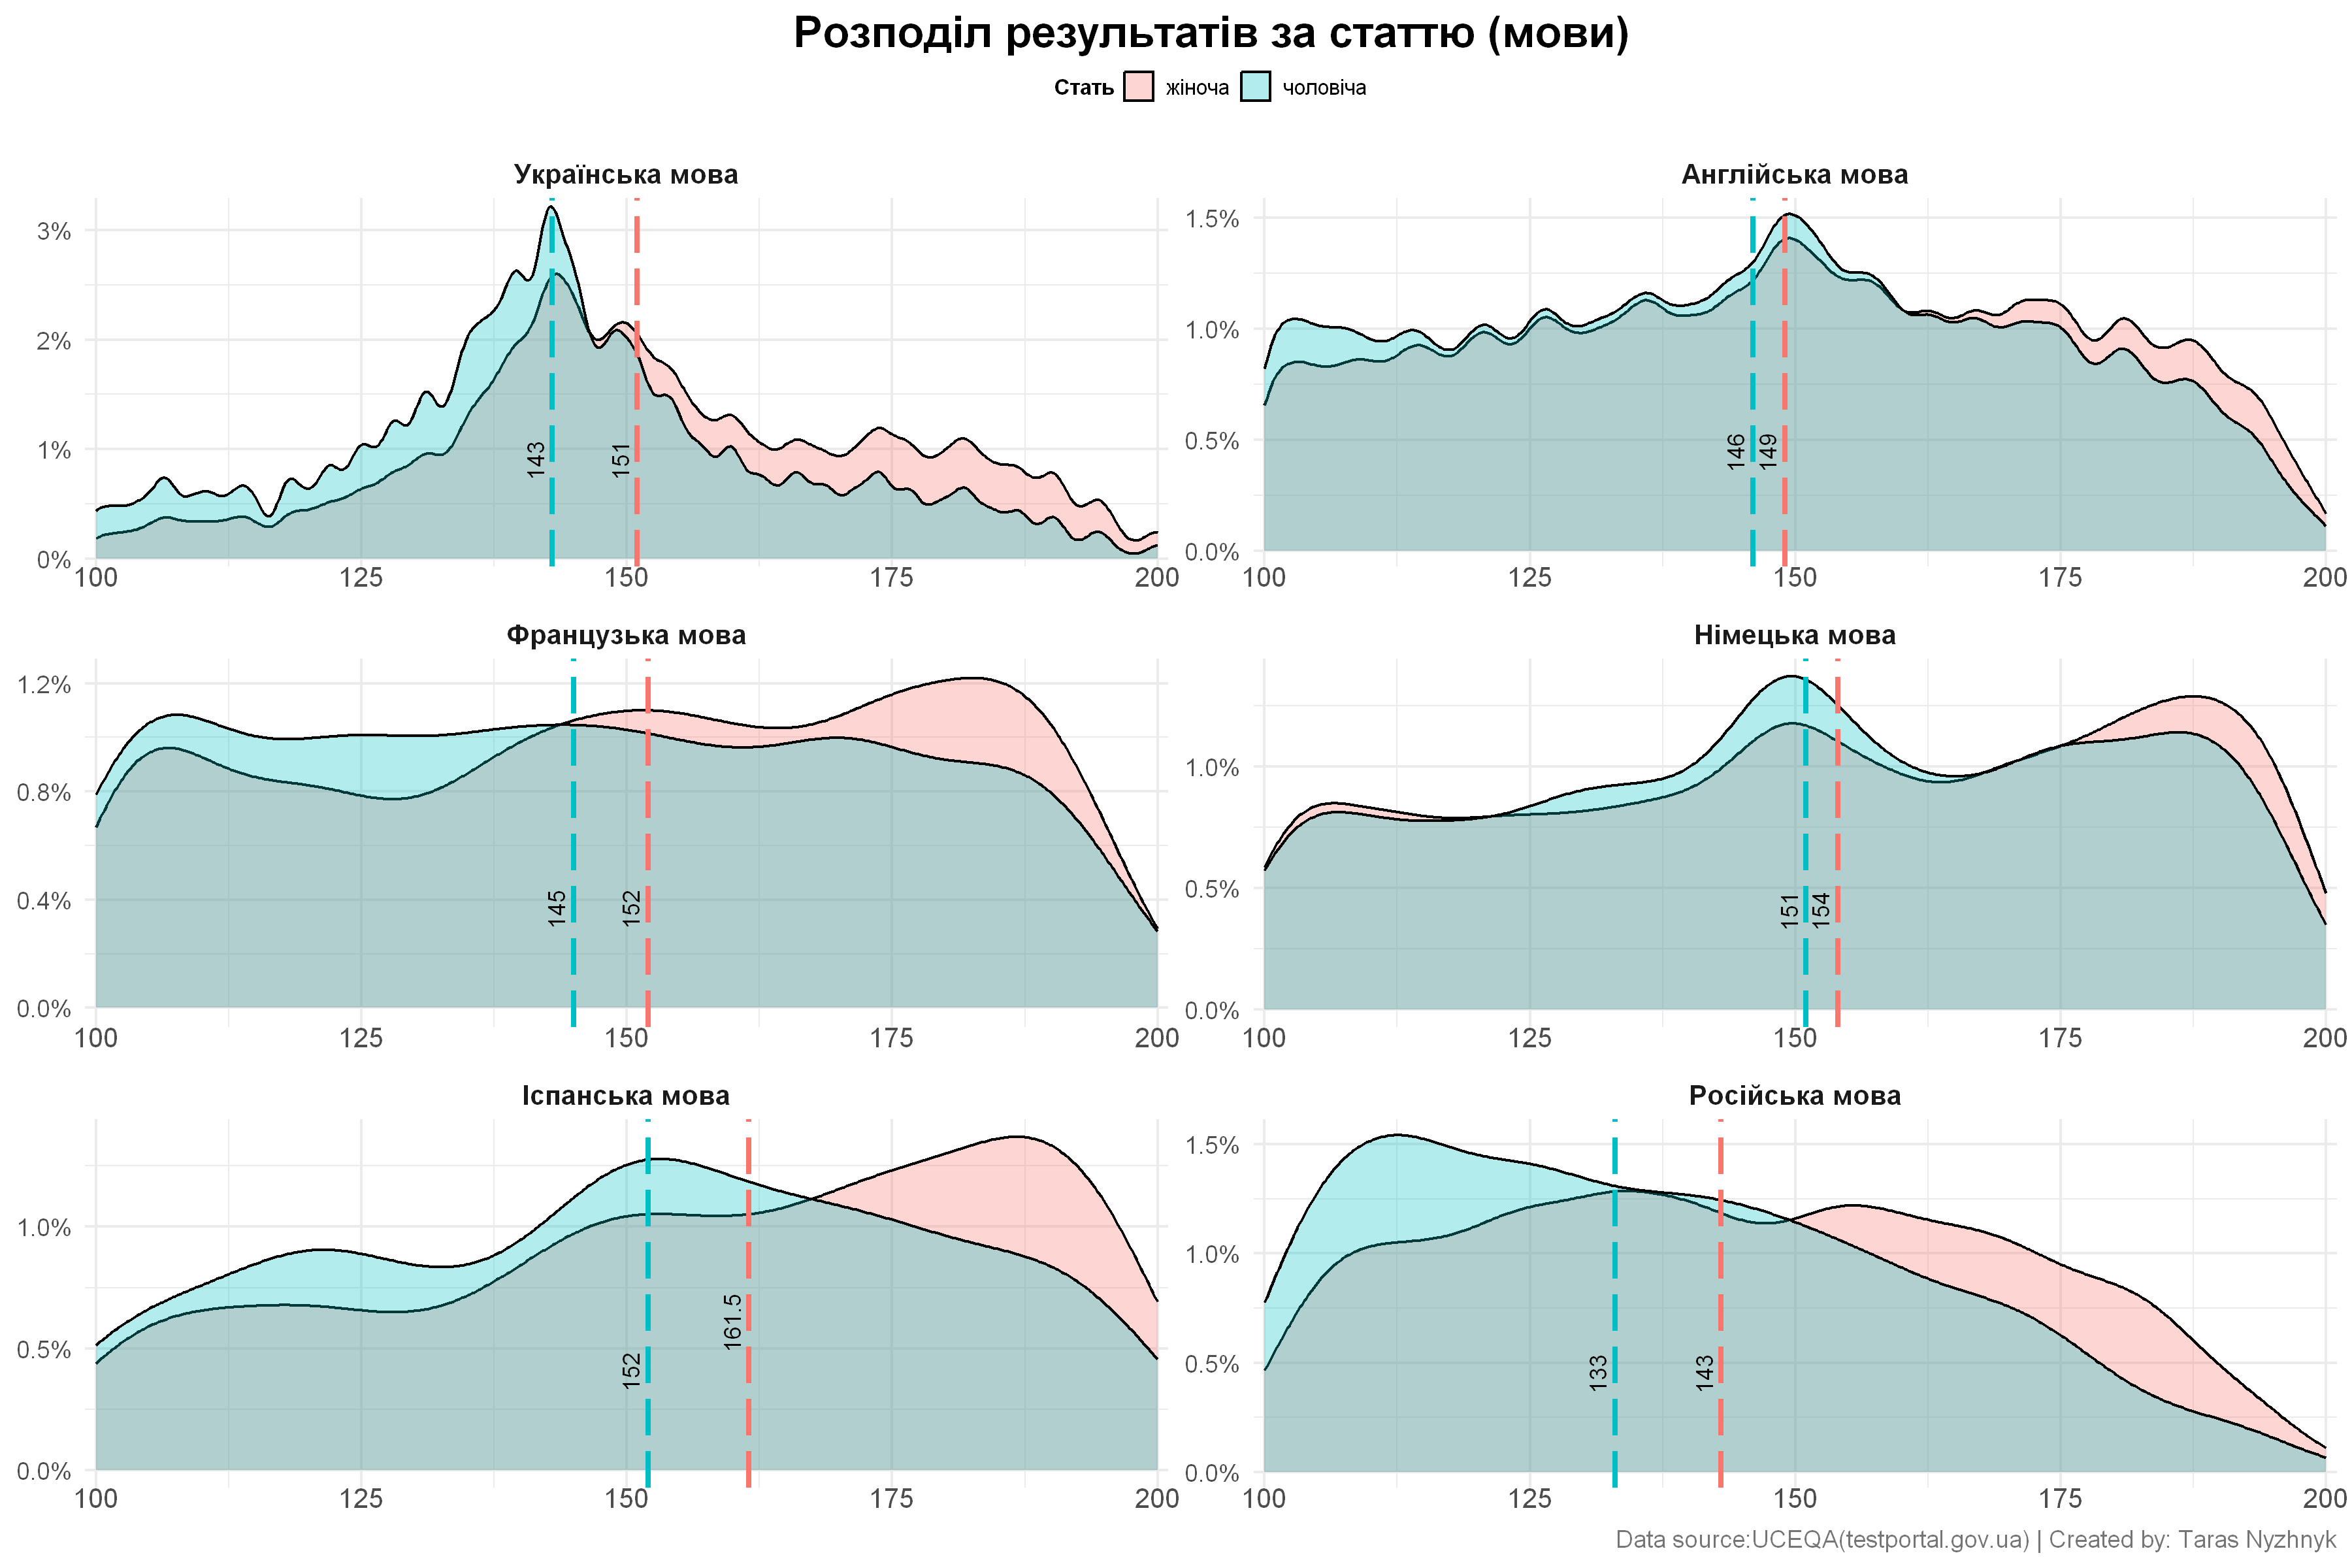

In [21]:
# calculate average ball per languages subjects of EIT
mball_l_subj <- zno_long_ball100 %>%
  filter(test %in% levels_l_subj) %>%
  group_by(test, sextypename) %>%
  summarize(s.median = median(ball100), .groups = "keep")

score_by_gender_l_subj <- zno_long_ball100 %>%
  filter(test %in% levels_l_subj)

ggplot(score_by_gender_l_subj) +
  aes(
    x = ball100,
    y = after_stat(prop),
    fill = sextypename,
    group = sextypename
  ) +
  geom_density(aes(y = after_stat(density)), alpha = .3, adjust = .9) +
  geom_vline(
    data = mball_l_subj, aes(xintercept = s.median, color = sextypename),
    linetype = "longdash", linewidth = 1, show.legend = FALSE
  ) +
  geom_text(
    data = mball_l_subj, aes(x = s.median, y = 0, label = s.median),
    angle = 90, hjust = -2, vjust = -0.5, size = 3
  ) +
  scale_y_continuous(labels = scales::percent, expand = c(0.0007, 0.0007)) +
  scale_x_continuous(limits = c(100, 200), expand = c(0.01, 0.01)) +
  facet_wrap(. ~ test, scales = "free", ncol = 2) +
  labs(fill = "Стать", x = "Бал") +
  ggtitle("Розподіл результатів за статтю (мови)") +
  caption +
  general_plot_config +
  theme(
    plot.title = element_text(margin = margin(0, 0, 0, 0)),
    axis.title.x = element_blank(),
    axis.text.x = element_text(margin = margin(-3, 0, 0, 0)),
    legend.key.size = unit(12, "pt")
  )


### 2.6 Test results distribution by gender and settlement type

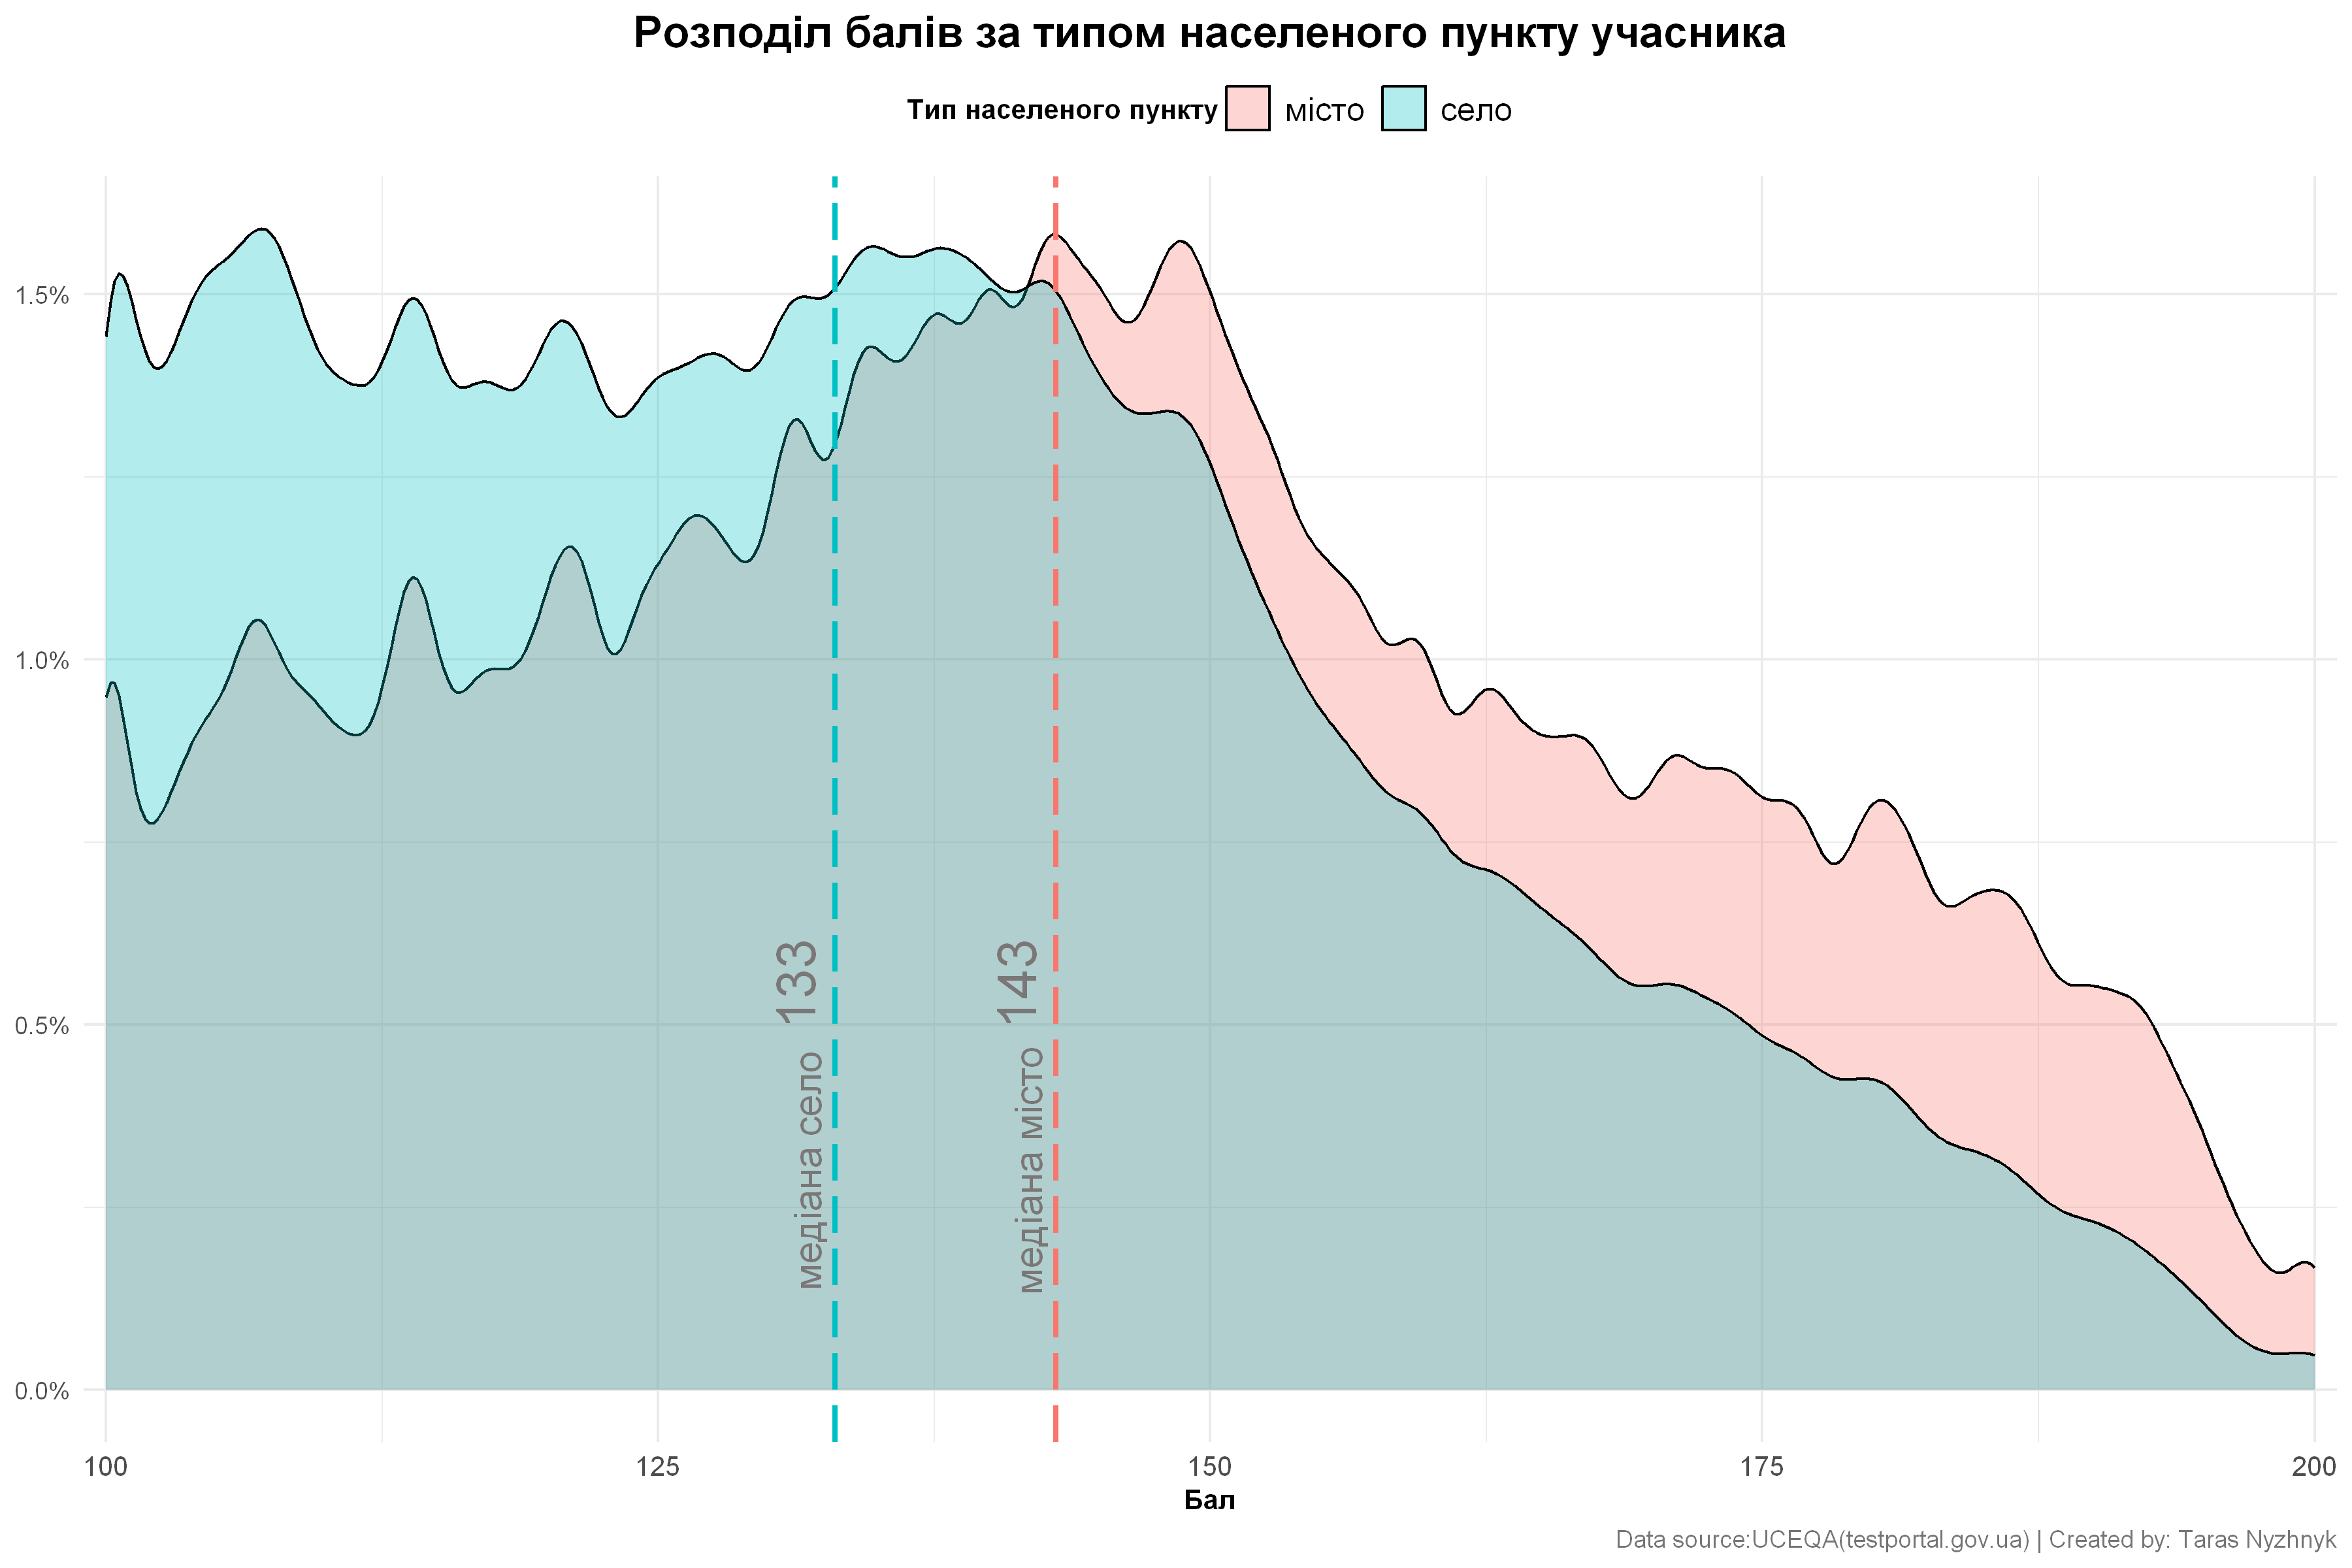

In [22]:
# calculate average ball per gender and settlement type
mball_settl <- zno_long_ball100 %>%
  group_by(tertypename) %>%
  summarize(s.median = median(ball100))

ggplot(zno_long_ball100) +
  aes(
    x = ball100,
    y = after_stat(density),
    group = tertypename,
    fill = tertypename
  ) +
  geom_density(alpha = .3) +
  geom_vline(
    data = mball_settl, aes(xintercept = s.median, color = tertypename),
    linetype = "longdash", linewidth = 1, show.legend = FALSE
  ) +
  geom_text(
    data = mball_settl, aes(x = s.median, y = 0, label = s.median),
    angle = 90, hjust = -4, vjust = -0.5, size = 7, color = "#7A7776"
  ) +
  scale_y_continuous(labels = scales::percent, expand = c(0.0007, 0.0007)) +
  scale_x_continuous(limits = c(100, 200), expand = c(0.01, 0.01)) +
  labs(fill = "Тип населеного пункту", x = "Бал") +
  ggtitle("Розподіл балів за типом населеного пункту учасника") +
  caption +
  general_plot_config +
  theme(
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 12)
  ) +
  annotate(
    geom = "text", x = mball_settl$s.median[mball_settl$tertypename == "місто"],
    y = 0.003, label = "медіана місто",
    size = 5, color = "#7A7776", angle = 90, vjust = -0.5
  ) +
  annotate(
    geom = "text", x = mball_settl$s.median[mball_settl$tertypename == "село"],
    y = 0.003, label = "медіана село",
    size = 5, color = "#7A7776", angle = 90, vjust = -0.5
  )


### 2.7 Average ball by subjects and years

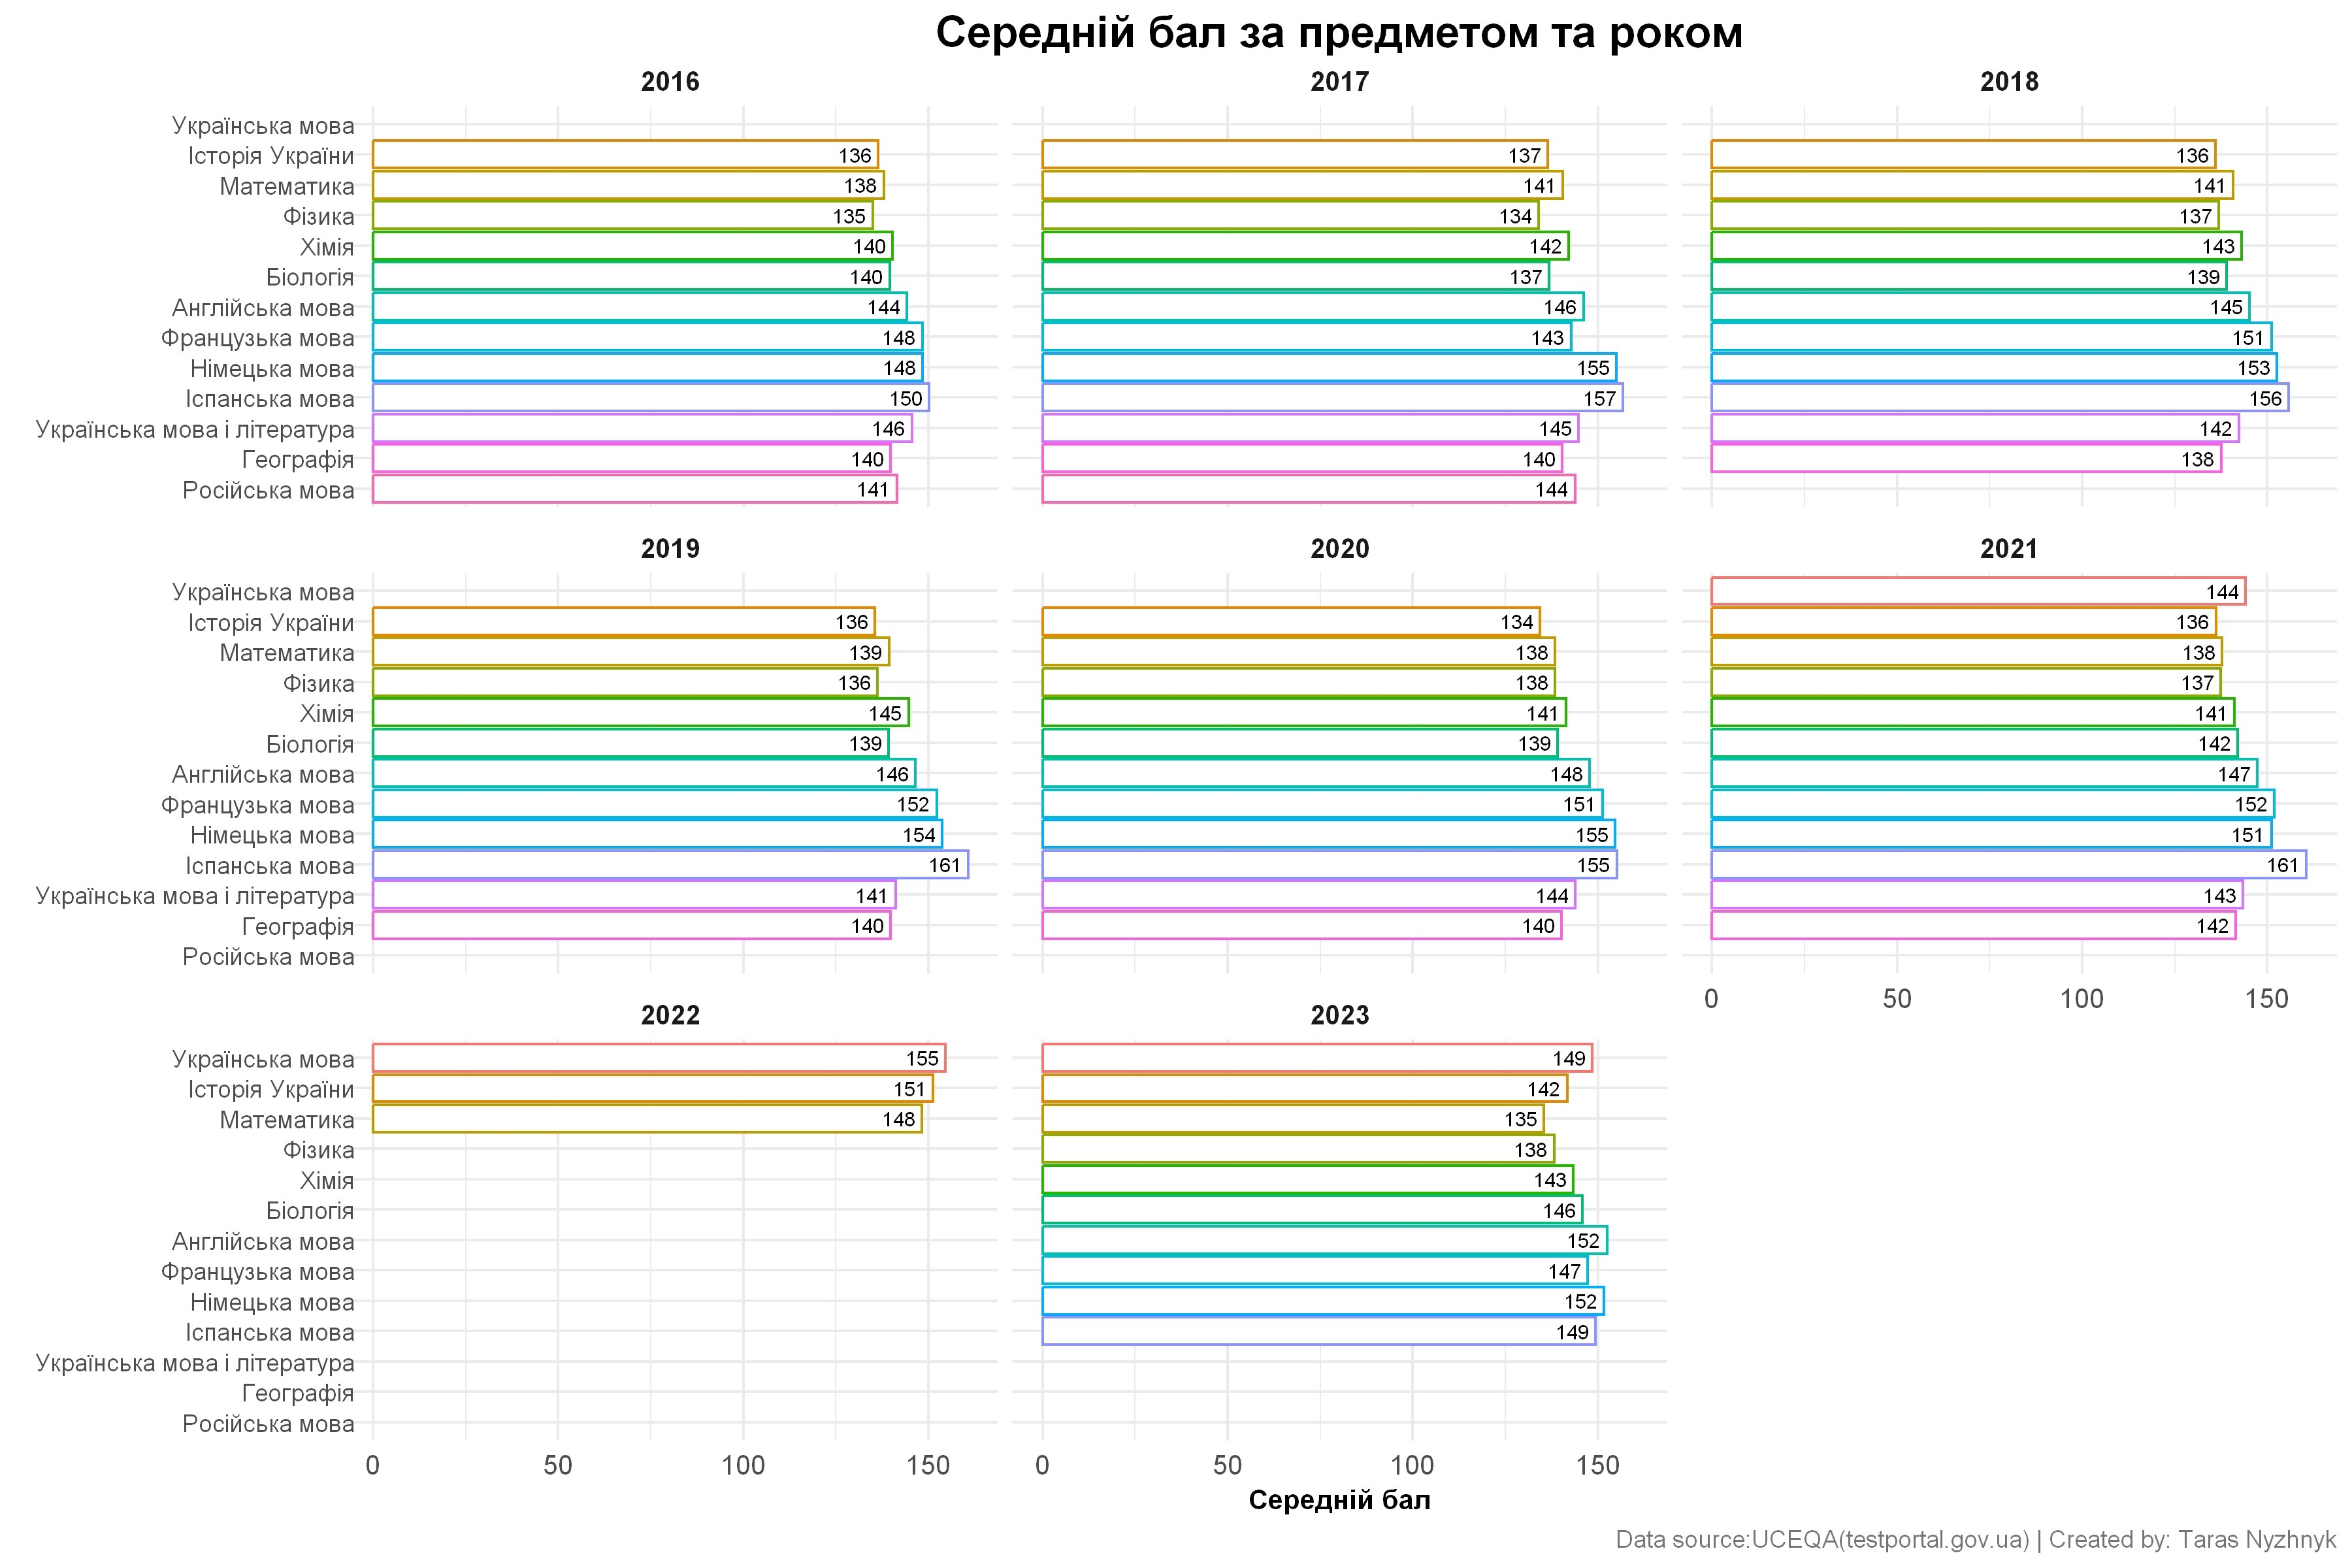

In [23]:
mean_score <- zno_long_ball100 %>%
  group_by(year, test) %>%
  summarize(s.mean = mean(ball100), .groups = "keep")

ggplot(mean_score) +
  aes(x = forcats::fct_rev(test), y = s.mean) +
  geom_col(aes(color = test), fill = "white") +
  geom_text(
    aes(label = round(s.mean, 0)),
    size = 2.5,
    vjust = 0.5,
    hjust = 1.2
  ) +
  coord_flip() +
  facet_wrap(~ factor(year)) +
  labs(y = "Середній бал") +
  labs(caption = capt) +
  ggtitle("Середній бал за предметом та роком") +
  caption +
  general_plot_config +
  theme(
    plot.title = element_text(margin = margin(0, 0, 0, 0)),
    axis.text.y = element_text(margin = margin(-7, -7, 0, 0)),
    legend.position = "none"
  )


### 2.8 Average ball by participant status and years

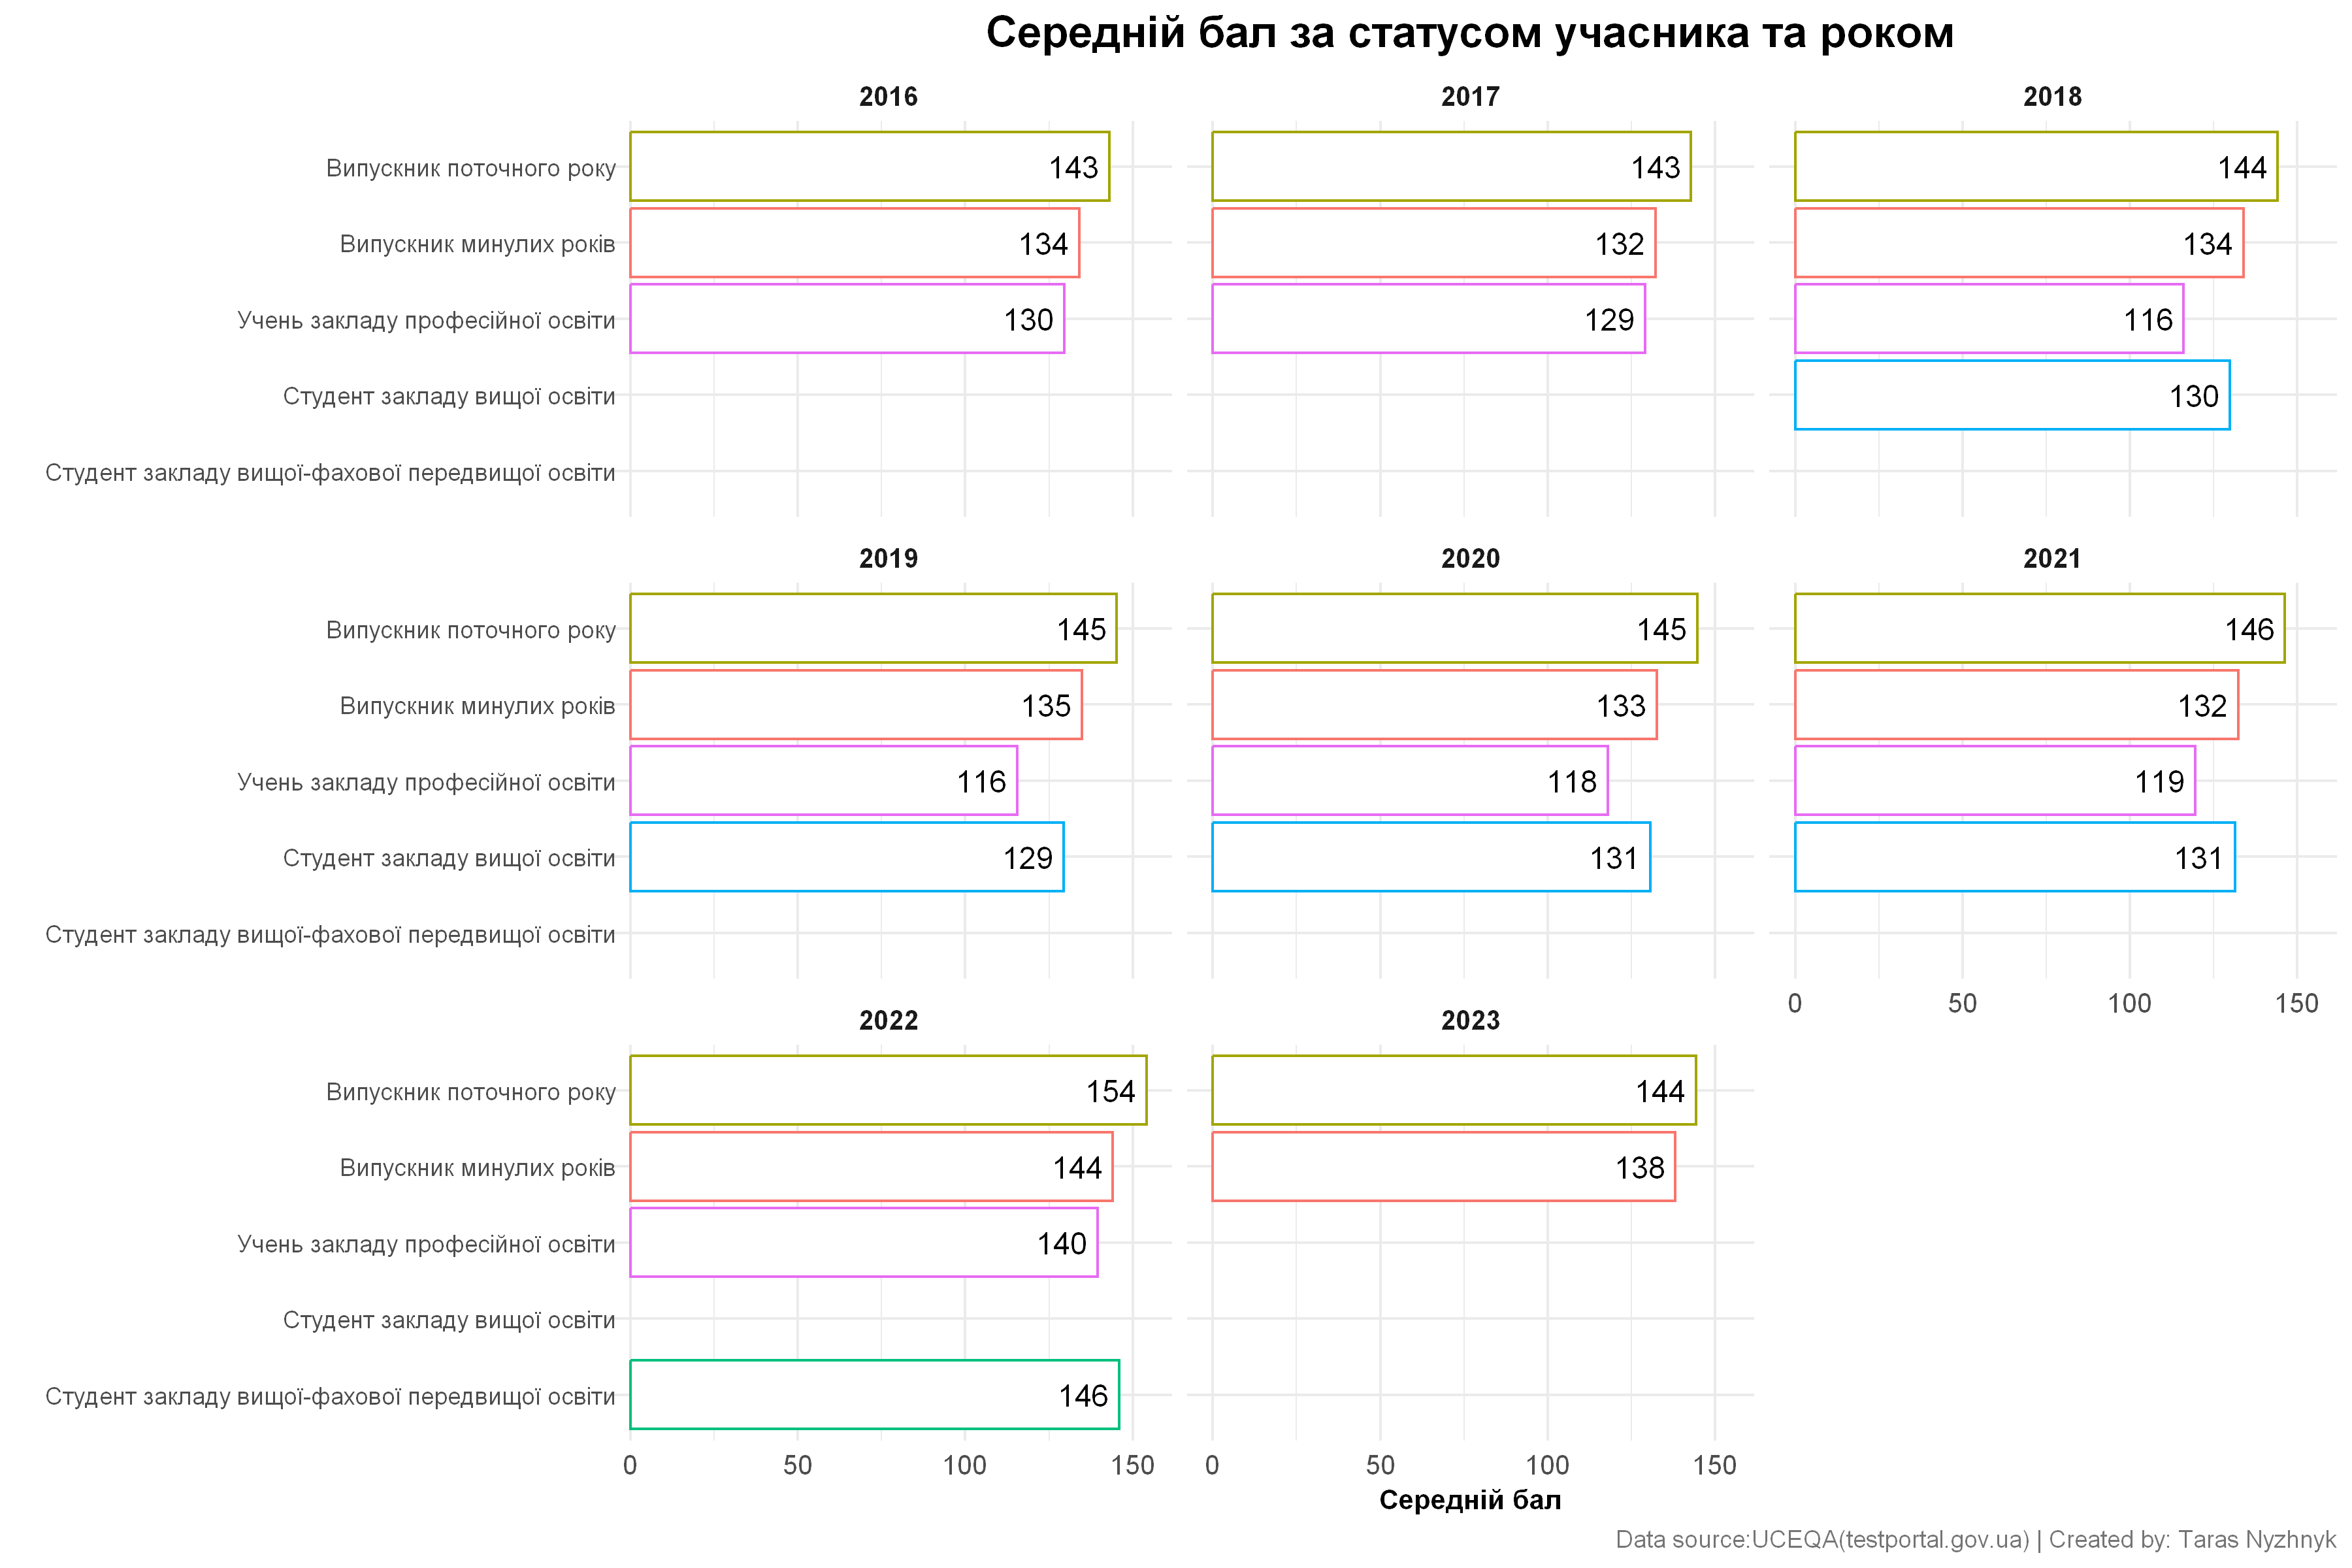

In [24]:
mean_score_regtypename <- zno_long_ball100 %>%
  group_by(year, regtypename) %>%
  summarize(s.mean = mean(ball100), .groups = "keep")

ggplot(mean_score_regtypename) +
  aes(x = factor(regtypename, levels = levels_grad), y = s.mean) +
  geom_col(aes(color = regtypename), fill = "white") +
  geom_text(aes(label = round(s.mean, 0)), size = 4, vjust = 0.5, hjust = 1.2) +
  coord_flip() +
  facet_wrap(~ factor(year)) +
  labs(y = "Середній бал") +
  ggtitle("Середній бал за статусом учасника та роком") +
  caption +
  general_plot_config +
  theme(
    axis.text.y = element_text(margin = margin(-7, -7, 0, 0)),
    legend.position = "none"
  )
